# CDNow网站用户消费行为分析

# 一、项目背景

CDNow曾经是一家在线音乐零售平台，后被德国波泰尔斯曼娱乐集团公司出资收购，其资产总价值在最辉煌时曾超过10亿美元。本文主要通过分析CDNow网站的用户购买明细来分析该网站的用户消费行为，使运营部门在营销时更加具有针对性，从而节省成本，提升效率。


# 二、数据来源
数据来源于国外网上，是用户在CDNow网站上的消费记录，数据包含了四个方面的信息：
- 用户ID user_id
- 购买日期 order_dt
- 订单数量 order_products
- 订单金额 order_amount

# 三、数据处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  #更改设计风格，使用自带的形式进行美化，这是一个r语言的风格.

# pd.set_option("display.max_columns",None) # 显示所有列
# pd.set_option("display.max_rows",None) # 显示所有行

In [2]:
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_csv('CDNOW_master.txt',names = columns,sep = '\s+') # 这份数据比较特殊，使用多个空格进行分割的,用\s+表示匹配任意空白符
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [3]:
# 描述性统计
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


- 大部分的订单值只消费了少量的商品（平均为2.4），有一定的极值干扰
- 用户的消费金额比较稳定平均消费35元，中位数在25元，有一定极值干扰
- 一般而言，消费类的数据分布，都是长尾形态。大部分用户都是小额，而小部分用户贡献了收入的大头，俗称消费二八法则。

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


- 总览数据概况，这里可以看出order_dt有问题，这里显示是整数类型的，但事实是日期形式的，需要清洗！！！

In [5]:
df['order_dt'] = pd.to_datetime(df.order_dt,format = '%Y%m%d') # 转换购买日期的数据格式
df['month'] = df.order_dt.astype('datetime64[M]') # 新增一个字段，将时间转换成相应的月份
df.head()

,user_id,order_dt,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


- pd.to_datetime可设置format参数来帮助这个函数理解原本的日期object，让这个函数能正确执行并且返回我们想要的结果
- pd.to_datetime可以将特定的字符串或者数字转换成时间格式，其中的format参数用于匹配。例如19970101，%Y匹配前四位数字1997，如果y小写只匹配两位数字97，%m匹配01，%d匹配01。
- 另外，小时是%h，分钟是%M，注意和月的大小写不一致，秒是%s。若是1997-01-01这形式，则是%Y-%m-%d，以此类推。
- astype也可以将时间格式进行转换，比如[M]转化成月份。我们将月份作为消费行为的主要事件窗口，选择哪种时间窗口取决于消费频率。
- astype('datetime64[M]') 操作的目的是新建一个名叫month的列，并且将日期保留年与月，将日统一设置为1，并且保存到month列中。

# 四、数据分析

## 1 用户总体消费趋势分析（按月）
- 每月的消费总金额
- 每月的消费次数
- 每月的产品购买量
- 每月的消费人数

In [6]:
grouped_month = df.groupby('month')
order_month_amount = grouped_month.order_amount.sum()
order_month_amount.head()

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
Name: order_amount, dtype: float64

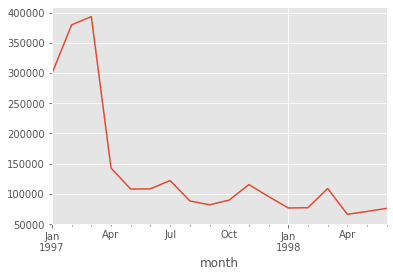

In [7]:
# plt.plot(order_month_amount)
plt.style.use('ggplot') # 更改设计风格，据说是模仿ggplot（R语言的一个的流行绘图包）的美学
order_month_amount.plot() # 每月消费金额

由上图可知，消费金额在前三个月达到最高峰，后续消费金额较为平稳，有轻微下降得趋势

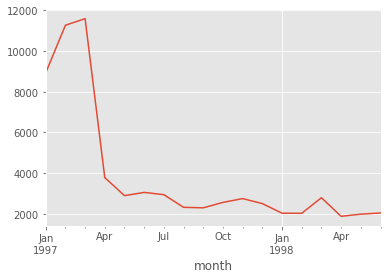

In [8]:
grouped_month.user_id.count().plot() # 每月消费次数

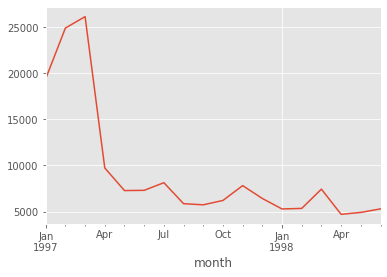

In [9]:
order_month_products = grouped_month.order_products.sum()
order_month_products.plot() # 每月产品购买量

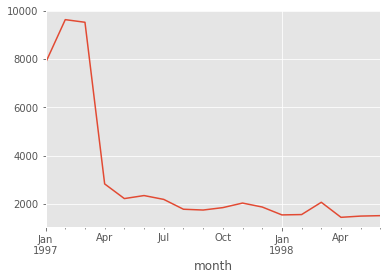

In [10]:
grouped_month.user_id.apply(lambda x: len(x.drop_duplicates())).plot() # 每月消费人数

每月消费人数低于每月消费次数，但是差异不大

前三个月每月消费人数在8000-10000之间，后续月份，平均消费人数在2000人数不到

#### 下面将以上四种消费情况放在一起绘图

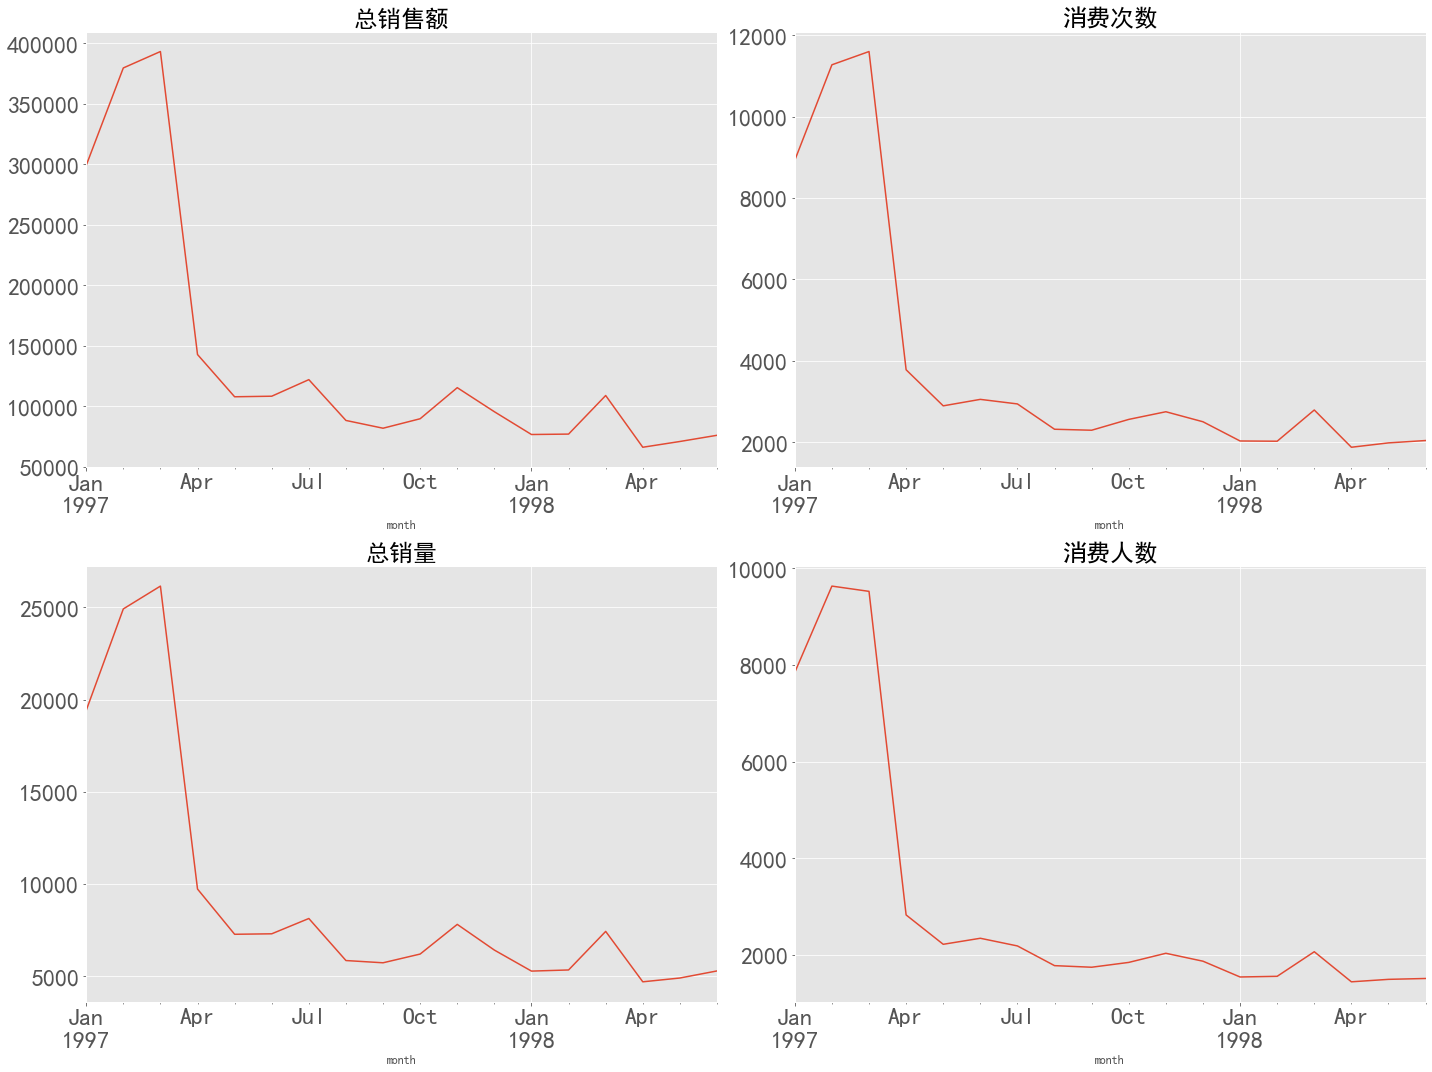

In [11]:
plt.rcParams['font.sans-serif']=['SimHei'] # 防止中文乱码

# 设置图的大小，添加子图
plt.figure(figsize=(20,15))
# 每月的总销售额
plt.subplot(221)
df.groupby('month')['order_amount'].sum().plot(fontsize=24) 
plt.title('总销售额',fontsize=24) 
 
#每月的消费次数
plt.subplot(222)
df.groupby('month')['user_id'].count().plot(fontsize=24)
plt.title('消费次数',fontsize=24) 

#每月的销量
plt.subplot(223)
df.groupby('month')['order_products'].sum().plot(fontsize=24)
plt.title('总销量',fontsize=24)

#每月的消费人数
plt.subplot(224)
df.groupby('month')['user_id'].apply(lambda x:len(x.unique())).plot(fontsize=24)
plt.title('消费人数',fontsize=24)
plt.tight_layout() # 设置子图的间距
plt.show()


- 四个折线图的整体趋势基本一致，可以看出，1997年前3个月的销量特别高，随之而来的销售额也是暴涨，在3月份之后骤然下降，接近平稳。
- 为什么会呈现这个原因呢？我们假设是用户身上出了问题，早期时间段的用户中有异常值，第二假设是各类促销营销，但这里只有消费数据，所以无法判断。
- 另一方面，在2月到3月这段时间，可以发现消费人数稍有下降，但总销量与总销售额却依然上升，是不是说明3月份的用户有我们需要重点发展的高价值客户呢？

**数据透视（另一种求上述分析的方法）**

In [12]:
df.pivot_table(index = 'month',
              values = ['order_products','order_amount','user_id'],
              aggfunc = {'order_products':'sum','order_amount':'sum','user_id':'count'},).head() 

,order_amount,order_products,user_id
month,,,
1997-01-01,299060.17,19416,8928
1997-02-01,379590.03,24921,11272
1997-03-01,393155.27,26159,11598
1997-04-01,142824.49,9729,3781
1997-05-01,107933.30,7275,2895


除此之外，还可以计算：
- 每月用户平均消费金额
- 每月用户平均消费次数

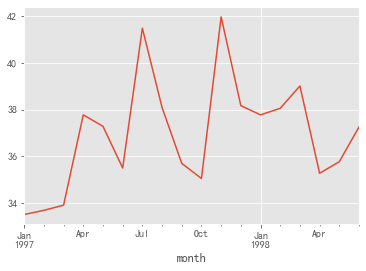

In [13]:
grouped_month.order_amount.mean().plot()

In [14]:
order_month_amount = grouped_month.order_amount.sum()
# grouped_month.user_id.apply(lambda x: len(x.drop_duplicates()))
order_month_amount

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
1997-06-01    108395.87
1997-07-01    122078.88
1997-08-01     88367.69
1997-09-01     81948.80
1997-10-01     89780.77
1997-11-01    115448.64
1997-12-01     95577.35
1998-01-01     76756.78
1998-02-01     77096.96
1998-03-01    108970.15
1998-04-01     66231.52
1998-05-01     70989.66
1998-06-01     76109.30
Name: order_amount, dtype: float64

In [15]:
user_month_id = grouped_month.user_id.apply(lambda x: len(x.drop_duplicates()))
user_month_id

month
1997-01-01    7846
1997-02-01    9633
1997-03-01    9524
1997-04-01    2822
1997-05-01    2214
1997-06-01    2339
1997-07-01    2180
1997-08-01    1772
1997-09-01    1739
1997-10-01    1839
1997-11-01    2028
1997-12-01    1864
1998-01-01    1537
1998-02-01    1551
1998-03-01    2060
1998-04-01    1437
1998-05-01    1488
1998-06-01    1506
Name: user_id, dtype: int64

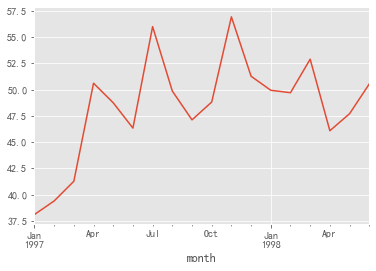

In [16]:
(order_month_amount/user_month_id).plot() # 每月用户平均消费金额

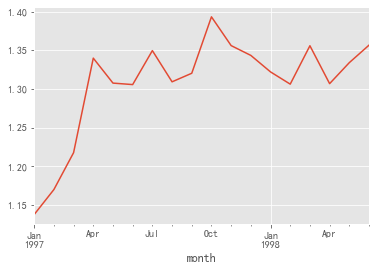

In [17]:
(grouped_month.user_id.count()/user_month_id ).plot()# 每月用户平均消费次数

## 2.用户个体消费分析

- 用户消费金额、消费次数的描述统计
- 用户消费金额和消费次数的散点图
- 用户消费金额的分布图
- 用户消费次数的分布图
- 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费额）

### 2.1 用户消费金额、消费次数的描述统计

In [18]:
grouped_user = df.groupby('user_id') # 按用户分成
grouped_user.sum().describe() # 用户消费金额、消费次数的描述统计

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


- 用户平均购买了7张CD，但是中位数只有3张，说明小部分用户买了大量的CD，符合二八法则。
- 用户平均消费了106元，中位数值是43元，判断同上，说明有极值干扰

### 2.2 用户消费金额和消费次数的散点图

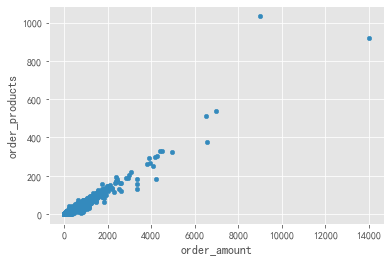

In [19]:
grouped_user.sum().plot.scatter(x = 'order_amount',y = 'order_products') # 用户消费订单数的散点图

从图中可以看出，有极值干扰，应该过滤掉

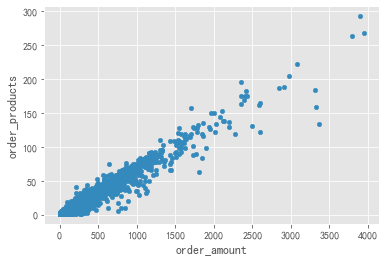

In [20]:
# 过滤极值
grouped_user.sum().query('order_amount<4000').plot.scatter(x = 'order_amount',y = 'order_products') 

- 绘制用户的散点图，用户比较健康而且规律性很强。因为这是CD网站的销售数据，商品比较单一，金额和商品量的关系也因此呈线性，没几个离群点。

### 2.3 用户消费金额的分布图（二八法则）

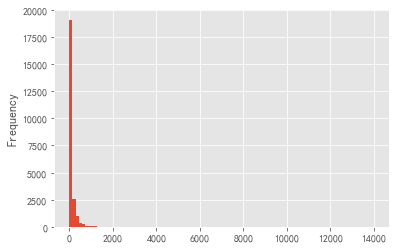

In [21]:
grouped_user.order_amount.sum().plot.hist(bins = 100) # 用户消费金额

- 从上图可以看出，用户的消费呈集中趋势，可能是有个别的极大值干扰导致。
- 可以排除极大值再看看分布情况。

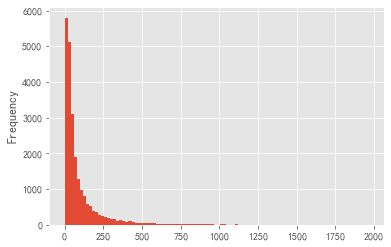

In [22]:
grouped_user.sum().query('order_amount<2000').order_amount.plot.hist(bins = 100) 

使用**切比雪夫定理**过滤掉异常值，计算95%的数据的分布情况

（在绝大多数的数据分布中，95%的数据都集中在距离平均数5个标准差之内）

##### 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费额）

In [23]:
user_cumsum = grouped_user.sum().sort_values('order_amount').apply(lambda x: x.cumsum()/x.sum())
user_cumsum

,order_products,order_amount
user_id,,
10175,0.000006,0.000000
4559,0.000012,0.000000
1948,0.000018,0.000000
925,0.000024,0.000000
10798,0.000030,0.000000
...,...,...
7931,0.982940,0.985405
19339,0.985192,0.988025
7983,0.988385,0.990814


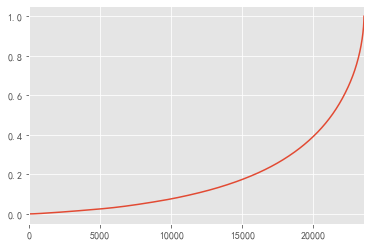

In [24]:
user_cumsum.reset_index().order_amount.plot()

这里的reset_index是为了防止作图时把user_id作为了横坐标而导致作图失败

按用户消费金额进行升序排列，有图可知50%的用户仅贡献了15%的消费额度，而排名前5000的用户就贡献了60%的消费额度

### 2.4 用户消费次数的分布图（二八法则）

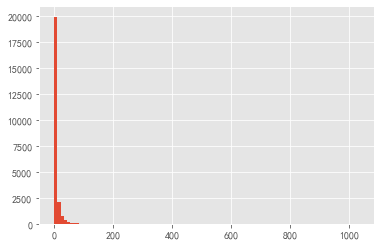

In [30]:
grouped_user.sum().order_products.hist(bins = 100) # 用户消费次数

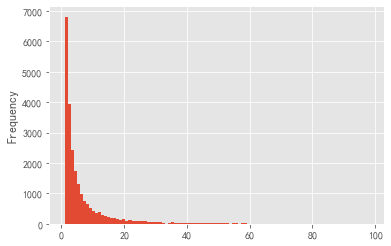

In [31]:
grouped_user.sum().query('order_products<100').order_products.plot.hist(bins = 100) 

- 大部分用户购买CD的数量都是在3张以内，购买大量CD的用户数量并不多。

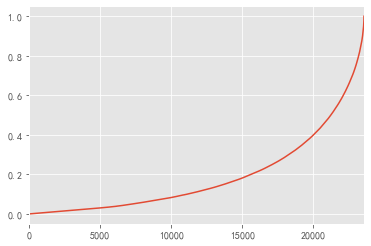

In [36]:
user_cumsum.reset_index().order_products.plot()

消费次数与消费金额的占比趋势一样

## 3 用户消费周期分析

- 用户购买周期（按订单）
    - 用户消费周期描述
    - 用户消费周期分布
- 用户生命周期（按第一次&最后一次消费）
    - 用户生命周期描述
    - 用户生命周期分布

### 3.1 用户购买周期（按订单）

In [37]:
order_diff = grouped_user.apply(lambda x : x.order_dt - x.order_dt.shift()) # 每个用户的每次购买时间间隔
order_diff.head(10)

user_id   
1        0        NaT
2        1        NaT
         2     0 days
3        3        NaT
         4    87 days
         5     3 days
         6   227 days
         7    10 days
         8   184 days
4        9        NaT
Name: order_dt, dtype: timedelta64[ns]

In [38]:
# df.order_dt.shift().head(10) # 所有数字向下平移一位
# print(order_dt.shift(2))行索引数字未发生改变，值向下移动两位

In [39]:
order_diff.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_dt, dtype: object

- 平均每个用户的购买时间间隔是68天，间隔最长的是533天。想要召回用户，在60天左右的消费间隔是比较好的。
- 绝大部分用户的消费周期都低于100天。

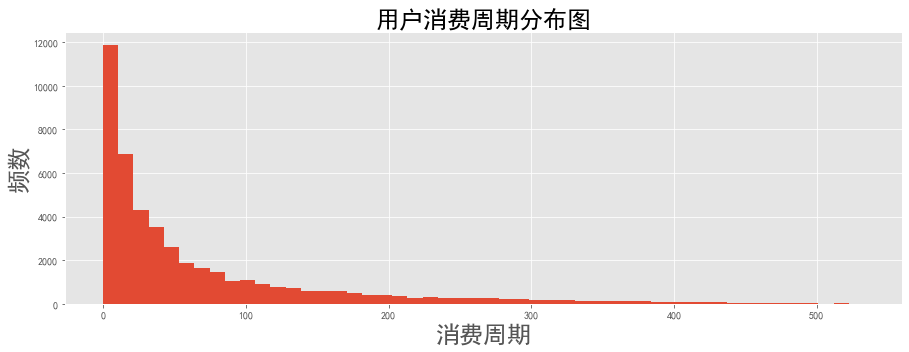

In [41]:
plt.figure(figsize=(15,5))
plt.hist((order_diff / np.timedelta64(1, 'D')).dropna(), bins = 50)
plt.xlabel('消费周期',fontsize=24)
plt.ylabel('频数',fontsize=24)
plt.title('用户消费周期分布图',fontsize=24);

- 订单周期呈典型的（指数）长尾分布
- 用户的平均购买周期是68天,绝大部分用户的购买周期(消费间隔)都低于100天
- 不妨将时间召回点设为消费后立即赠送优惠券，消费后10天询问用户礼品怎么样，消费后20天提醒优惠券到期，消费后30天短信推送。

### 3.2 用户生命周期（按第一次&最后一次消费）

In [42]:
orderdt_min=df.groupby('user_id').order_dt.min()#第一次消费
orderdt_max=df.groupby('user_id').order_dt.max()#最后一次消费
(orderdt_max-orderdt_min).head()

user_id
1     0 days
2     0 days
3   511 days
4   345 days
5   367 days
Name: order_dt, dtype: timedelta64[ns]

In [43]:
#计算用户的平均生命周期
(orderdt_max-orderdt_min).mean()

Timedelta('134 days 20:55:36.987696')

- 所有用户的平均生命周期是134天，比预想的高，但是平均数不具有代表性，接下来还是看一下分布情况。

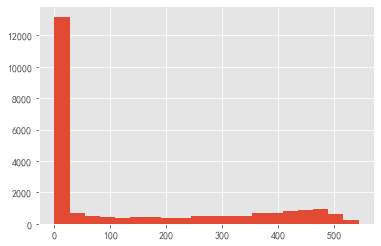

In [44]:
((orderdt_max-orderdt_min)/np.timedelta64(1,'D')).hist(bins=20)
#因为数据类型是timedelta时间，无法直接作出直方图，所以先换算成数值。
#换算的方式直接除timedelta函数即可，np.timedelta64(1, ‘D’)，D表示天，1表示1天，作为单位使用的。
#因为max-min已经表示为天了，两者相除就是周期

- 用户的生命周期受只购买一次的用户影响比较厉害（可以排除）
- 用户均消费134天，中位数仅10天
- 但这不是我们想要的答案，接下来将只购买一次的用户过滤掉（即间隔天数为0的），来计算所有消费过两次以上的老客的生命周期。

In [45]:
life_time = (orderdt_max - orderdt_min).reset_index()
life_time.head()

,user_id,order_dt
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days


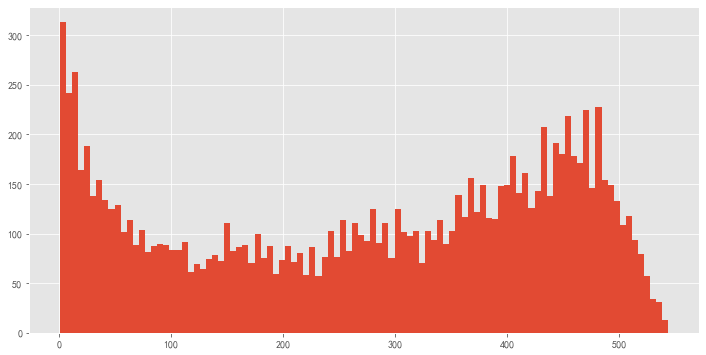

In [46]:
#用户生命周期分布图
plt.figure(figsize=(10,5))
life_time['life_time'] = life_time.order_dt / np.timedelta64(1,'D')
life_time[life_time.life_time > 0].life_time.hist(bins = 100, figsize = (12,6))

- 上图可见，用户生命周期呈现双峰趋势，20天内生命周期的用户是一个高峰，400至500天内生命周期的用户是另一个高峰。
- 根据此情况，应该在20天内对客户进行引导，促进其再次消费并形成消费习惯，延长其生命周期；在100至400天的用户，也要根据其特点推出有针对性的营销活动，引导其持续消费。 分析去掉0天生命周期的用户之后的用户生命周期的平均值。

In [48]:
#去掉0天生命周期的用户之后的用户生命周期的平均值
life_time[life_time.life_time>0].order_dt.mean()

Timedelta('276 days 01:04:31.344216')

- 可见，若在用户首次消费后，加强对其再次消费的引导，可将其生命周期延长至原来的两倍。

## 4 用户分层
- RFM
- 新、老、活跃、回流、流失/不活跃

### 4.1 RFM指标（人工地使用象限法将用户划分为几个立方体，对应的标签可应用于业务层面上）
- 最近一次消费（Recency）
- 消费频率（Frequency）
- 消费金额（Monetary）

In [49]:
rfm = df.pivot_table(index = 'user_id',
                    values = ['order_products','order_amount','order_dt'],
                    aggfunc = {'order_products':'sum',
                              'order_amount':'sum',
                              'order_dt':'max'})
rfm.head()

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [50]:
# 用户最近一次（最后一次）消费的时间与现在（这里用了所有时间里最后一次时间代替）的时间差
-(rfm.order_dt - rfm.order_dt.max()) 

user_id
1       545 days
2       534 days
3        33 days
4       200 days
5       178 days
          ...   
23566   462 days
23567   462 days
23568   434 days
23569   462 days
23570   461 days
Name: order_dt, Length: 23570, dtype: timedelta64[ns]

从上面可看出，这里的时间类型是时间格式，对后期的计算会有些麻烦，所以我们要把时间变为具体的数字（np.timedelta64(1,'D')是天的单位）

In [51]:
rfm['R'] = -(rfm.order_dt - rfm.order_dt.max())/np.timedelta64(1,'D')  # 把天的单位消除掉，变成了一个浮点数
rfm

,order_amount,order_dt,order_products,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0
...,...,...,...,...
23566,36.00,1997-03-25,2,462.0
23567,20.97,1997-03-25,1,462.0
23568,121.70,1997-04-22,6,434.0


In [52]:
rfm.rename(columns = {'order_products':'F','order_amount':'M'},inplace = True)
rfm

,M,order_dt,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0
...,...,...,...,...
23566,36.00,1997-03-25,2,462.0
23567,20.97,1997-03-25,1,462.0
23568,121.70,1997-04-22,6,434.0


In [53]:
rfm[['R','F','M']].apply(lambda x: x - x.mean())

,R,F,M
user_id,,,
1,177.778362,-6.122656,-94.310426
2,166.778362,-1.122656,-17.080426
3,-334.221638,8.877344,50.379574
4,-167.221638,-0.122656,-5.580426
5,-189.221638,21.877344,279.529574
...,...,...,...
23566,94.778362,-5.122656,-70.080426
23567,94.778362,-6.122656,-85.110426
23568,66.778362,-1.122656,15.619574


将用户均分为：高于平均消费额度的用户，以及低于平均消费额度的用户。（正数表示高于平均值，负数表示低于平均值）

In [54]:
# 构建rfm模型公式
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要挽留客户',
        '001':'重要发展客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般挽留客户',
        '000':'一般发展客户'}
    result = d[label]
    return result

rfm['label'] = rfm[['R','F','M']].apply(lambda x: x - x.mean()).apply(rfm_func,axis = 1) # 逐行应用

In [55]:
rfm.head()

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般挽留客户
2,89.00,1997-01-12,6,534.0,一般挽留客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般发展客户
5,385.61,1998-01-03,29,178.0,重要保持客户


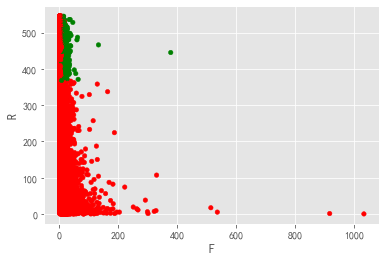

In [56]:
# 可视化
rfm.loc[rfm.label == '重要价值客户','color'] = 'g'
rfm.loc[~(rfm.label == '重要价值客户'),'color'] = 'r'
rfm.plot.scatter('F','R',c = rfm.color)

In [57]:
rfm.groupby('label').count() # 计数

,M,order_dt,F,R,color
label,,,,,
一般价值客户,77,77,77,77,77
一般保持客户,206,206,206,206,206
一般发展客户,3300,3300,3300,3300,3300
一般挽留客户,14074,14074,14074,14074,14074
重要价值客户,787,787,787,787,787
重要保持客户,4554,4554,4554,4554,4554
重要发展客户,331,331,331,331,331
重要挽留客户,241,241,241,241,241


In [58]:
rfm.groupby('label').sum() # 求和

,M,F,R
label,,,
一般价值客户,7181.28,650,36295.0
一般保持客户,19937.45,1712,29448.0
一般发展客户,196971.23,13977,591108.0
一般挽留客户,438291.81,29346,6951815.0
重要价值客户,167080.83,11121,358363.0
重要保持客户,1592039.62,107789,517267.0
重要发展客户,45785.01,2023,56636.0
重要挽留客户,33028.40,1263,114482.0


从RFM分层可知，一般挽留用户的消费人数排名第一，有14074人，重要保持客户排名第二，有4554人，与一般挽留用户差距比较大，但累计消费金额最多，业务方可以根据结果对客户分类运营，降低营销成本，提高ROI。

大部分的用户为重要保持客户（累计消费金额最高），但是这是由于极值的影响（会影响到平均值），所以RFM得划分标准应该以业务为准
- 尽量用小部分的用户覆盖大部分的额度
- 不要为了数据好看划分等级

**思考**：重要保持客户的贡献金额最多，那么如何与业务方配合，把数据提高或者维护？重要发展/挽留客户有一段时间没有消费了，那么如何去拉回来？

### 4.2 新、老、活跃、回流、流失/不活跃

In [59]:
pivoted_counts = df.pivot_table(index = 'user_id',
                               columns = 'month',
                               values = 'order_dt',
                               aggfunc = 'count').fillna(0)
pivoted_counts.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [60]:
df_purchase = pivoted_counts.applymap(lambda x :1 if x>0 else 0)
df_purchase.tail() # 查看尾部数据
df_purchase.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [61]:
# 多重判断。一二月份的0对于一些三月份才开始第一次消费是一个陷阱
def active_status(data):
    status = []
    for i in range(18): # 逐月判断
        
        # 若本月没有消费
        if data[i] == 0:
            if len(status)>0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        
        # 若本月消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return status

unreg 未注册，unactive不活跃，new新增用户，active活跃，return回流

若本月没有消费
- 若之前是未注册，则依旧为未注册
- 若之前有消费，则为流失/不活跃
- 其他情况，为未注册

若本月有消费
- 若是第一次消费，则为新用户
- 如果之前有过消费，则上个月为不活跃，则为回流
- 如果上个月为未注册，则为新用户
- 除此之外，为活跃

In [64]:
purchase_stats = df_purchase.apply(active_status,axis = 1,result_type = 'expand') # 这里在apply中添加result_type = 'expand'是为了将dic格式转换为dataframe
purchase_stats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


不知为啥这里的列名发生了变化，所以下面需要重置列名

In [65]:
purchase_stats.columns = df_purchase.columns # 重置列名
purchase_stats.tail()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
23566,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23567,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23568,unreg,unreg,new,active,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23569,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23570,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive


In [66]:
purchase_stats_ct = purchase_stats.replace('unreg',np.NaN).apply(lambda x: pd.value_counts(x)) # 对列中元素进行计数
purchase_stats_ct.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


In [67]:
purchase_stats_ct.fillna(0).T.head()

,active,new,return,unactive
month,,,,
1997-01-01,0.0,7846.0,0.0,0.0
1997-02-01,1157.0,8476.0,0.0,6689.0
1997-03-01,1681.0,7248.0,595.0,14046.0
1997-04-01,1773.0,0.0,1049.0,20748.0
1997-05-01,852.0,0.0,1362.0,21356.0


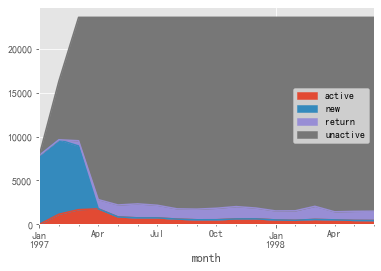

In [68]:
purchase_stats_ct.fillna(0).T.plot.area() # 作面积图

In [69]:
purchase_stats_ct.fillna(0).T.apply(lambda x : x / x.sum(),axis = 1) # axis = 1 指从左到右方向校验

,active,new,return,unactive
month,,,,
1997-01-01,0.000000,1.000000,0.000000,0.000000
1997-02-01,0.070886,0.519299,0.000000,0.409815
1997-03-01,0.071319,0.307510,0.025244,0.595927
1997-04-01,0.075223,0.000000,0.044506,0.880272
1997-05-01,0.036148,0.000000,0.057785,0.906067
1997-06-01,0.031693,0.000000,0.067543,0.900764
1997-07-01,0.031650,0.000000,0.060840,0.907510
1997-08-01,0.025626,0.000000,0.049555,0.924820
1997-09-01,0.022401,0.000000,0.051379,0.926220


由上表可知，每月的用户消费状态变化
- 活跃用户，持续消费的用户，对应的是消费运营的质量
- 回流用户，之前不消费本月才消费，对应的是唤回运营
- 不活跃用户，对应的事流失

如果是回流多了，说明促销比较好。如果是新增多了，说明是渠道部门和市场部门比较给力。

## 5 用户质量分析
- 用户第一次消费（首购）
- 用户最后一次消费
- 新老客户消费比
    - 多少用户仅消费了一次？
    - 每月新客户占比？
- 复购率和回购率
    - 复购率
        - 自然月内，购买多次的用户占比
    - 回购率
        - 曾经购买过得用户在某一时期内的再次购买占比

### 5.1 用户第一次消费（首购）

In [71]:
grouped_user.order_dt.min()

user_id
1       1997-01-01
2       1997-01-12
3       1997-01-02
4       1997-01-01
5       1997-01-01
           ...    
23566   1997-03-25
23567   1997-03-25
23568   1997-03-25
23569   1997-03-25
23570   1997-03-25
Name: order_dt, Length: 23570, dtype: datetime64[ns]

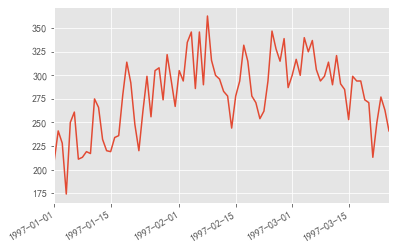

In [72]:
grouped_user.order_dt.min().value_counts().plot()

**用户的第一次购买分布（每个月的新增用户趋势）**，新增用户集中在前三个月

其中，在2月11日至2月25日有一次剧烈的波动

### 5.2 用户最后一次消费

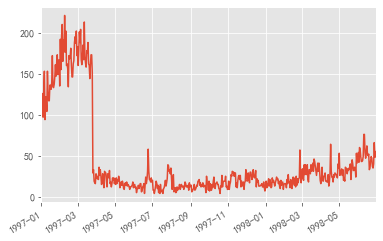

In [73]:
grouped_user.order_dt.max().value_counts().plot()

**用户的最后一次购买的分布**比第一次分布广
- 大部分最后一次购买集中在前三个月，说明有很多用户购买了一次后就不再进行购买。后面的月份大多数是老客户在消费
- 随着时间的递增，最后一次购买数也在递增，消费呈现流失上升的状况

### 5.3 新老客户消费比

#### 5.3.1 多少用户仅消费了一次？

In [74]:
user_life = grouped_user.order_dt.agg(['min','max'])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


In [75]:
(user_life['min']==user_life['max']).value_counts()

True     12054
False    11516
dtype: int64

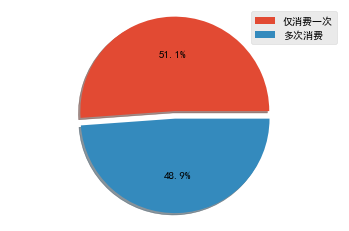

In [76]:
# 作图
new_old = (user_life['min']==user_life['max']).value_counts()
plt.pie(x = new_old,
       autopct = '%.1f%%',
       shadow = True,
       explode = [0.08,0],
       textprops = {'fontsize' : 11})
plt.axis('equal') 
plt.legend(['仅消费一次','多次消费'])

从结果可知，有一半用户就**消费了一次**，这也说明运营不利，留存效果不好。

#### 5.3.2 每月新客户占比

In [81]:
user_new = grouped_user.order_dt.min().value_counts()# 新用户(新增用户)数量
# user_new.columns = ['month','new']
user_new

1997-02-08    363
1997-02-24    347
1997-02-04    346
1997-02-06    346
1997-03-04    340
             ... 
1997-01-08    213
1997-03-21    213
1997-01-07    211
1997-01-01    209
1997-01-04    174
Name: order_dt, Length: 84, dtype: int64

In [82]:
dict_order_dt = {'day':user_new.index,'numbers':user_new.values}
df_order_dt = pd.DataFrame(dict_order_dt)
df_order_dt['month'] = df_order_dt.day.astype('datetime64[M]') # 新增一个字段，将时间转换成相应的月份
df_order_dt

,day,numbers,month
0,1997-02-08,363,1997-02-01
1,1997-02-24,347,1997-02-01
2,1997-02-04,346,1997-02-01
3,1997-02-06,346,1997-02-01
4,1997-03-04,340,1997-03-01
...,...,...,...
79,1997-01-08,213,1997-01-01
80,1997-03-21,213,1997-03-01
81,1997-01-07,211,1997-01-01
82,1997-01-01,209,1997-01-01


In [83]:
user_month_new = df_order_dt.groupby('month').numbers.sum() # 每月新增用户
user_month_new 

month
1997-01-01    7846
1997-02-01    8476
1997-03-01    7248
Name: numbers, dtype: int64

In [84]:
user_month = grouped_month.user_id.apply(lambda x: len(x.drop_duplicates())) # 每月消费人数
user_month

month
1997-01-01    7846
1997-02-01    9633
1997-03-01    9524
1997-04-01    2822
1997-05-01    2214
1997-06-01    2339
1997-07-01    2180
1997-08-01    1772
1997-09-01    1739
1997-10-01    1839
1997-11-01    2028
1997-12-01    1864
1998-01-01    1537
1998-02-01    1551
1998-03-01    2060
1998-04-01    1437
1998-05-01    1488
1998-06-01    1506
Name: user_id, dtype: int64

In [85]:
user_month_new/user_month # 每月新客户占比

month
1997-01-01    1.000000
1997-02-01    0.879892
1997-03-01    0.761025
1997-04-01         NaN
1997-05-01         NaN
1997-06-01         NaN
1997-07-01         NaN
1997-08-01         NaN
1997-09-01         NaN
1997-10-01         NaN
1997-11-01         NaN
1997-12-01         NaN
1998-01-01         NaN
1998-02-01         NaN
1998-03-01         NaN
1998-04-01         NaN
1998-05-01         NaN
1998-06-01         NaN
dtype: float64

以上则为每月新增客户占比，前三个月都有新增用户，后面几个月都没有了

### 5.4 复购率和回购率
- 复购率
    - 自然月内，购买多次的用户占比
- 回购率
    - 曾经购买过得用户在某一时期内的再次购买占比

#### 5.4.1 复购率
- 当月消费过一次以上的用户

In [86]:
pivoted_counts

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23566,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23567,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23568,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
purchase_r = pivoted_counts.applymap(lambda x: 1 if x> 1 else np.NaN if x==0 else 0)
purchase_r.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


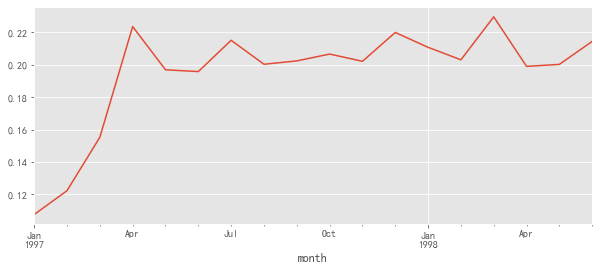

In [88]:
#count统计所有非空数据个数表示总消费用户数，sum计算非0数据的和表示消费两次以上的用户数
(purchase_r.sum()/purchase_r.count()).plot(figsize = (10,4))

Text(0.5, 1.0, '复购率的变化')

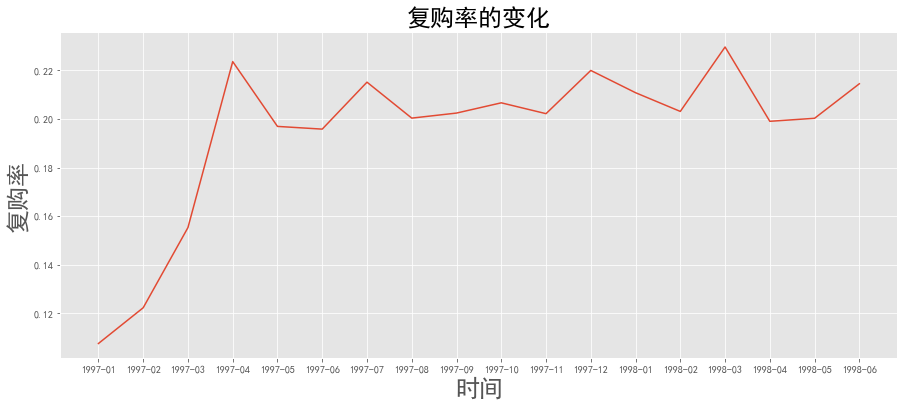

In [89]:
df_duplicate =pd.DataFrame(purchase_r.sum()/purchase_r.count()).reset_index()
df_duplicate.columns = ['Date', 'DuplicatedRate']
df_duplicate['Date'] = df_duplicate.Date.astype(str).apply(lambda x:x[:-3])

plt.figure(figsize = (15,6))
plt.plot(df_duplicate.Date, df_duplicate.DuplicatedRate)
plt.xlabel('时间', fontsize=24)
plt.ylabel('复购率',fontsize=24)
# plt.ylim(0,1)
plt.title('复购率的变化',fontsize=24)

- 复购率稳定在20%左右，前三个月因为有大量新用户涌入，而这批用户只购买了一次，所以导致复购率降低。单看新客和老客，复购率有三倍左右的差距。

#### 5.4.2 回购率
- 当月消费过的用户在次月依旧消费

In [91]:
df_purchase.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [92]:
def purchase_back(data):
    status = []
    for i in range(17):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN) # 最后一个月的回购率不参与计算，因为后面没有月份了
    return status

In [93]:
purchase_b = df_purchase.apply(purchase_back,axis = 1,result_type = 'expand')
purchase_b.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


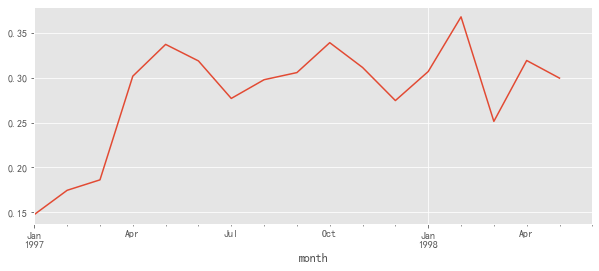

In [94]:
purchase_b.columns = df_purchase.columns  # 更换列名
(purchase_b.sum()/purchase_b.count()).plot(figsize=(10,4))

Text(0.5, 1.0, '回购率的变化')

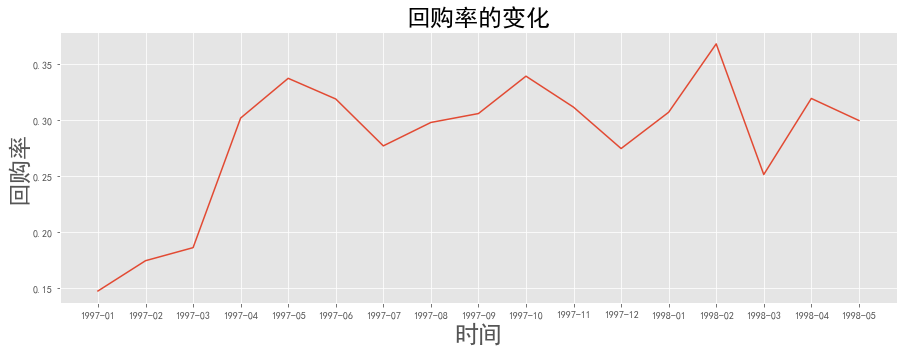

In [95]:
df_purchase = (purchase_b.sum()/purchase_b.count()).reset_index()
df_purchase.columns = ['Date', 'PurchaseRate']
df_purchase['Date'] = df_purchase.Date.astype(str).apply(lambda x:x[:-3])

plt.figure(figsize = (15,5))
plt.plot(df_purchase.Date, df_purchase.PurchaseRate)
plt.xlabel('时间', fontsize=24)
plt.ylabel('回购率', fontsize=24)
plt.title('回购率的变化', fontsize=24)

- 上图可以看出，在初期用户的回购率并不高，1月的回购率只有15%左右，4月份起回购率稳定在30%左右。
- 从每月有回购消费的用户数数据可以看出，回购用户数整体有下降趋势。
- 对回购率的分析，再次说明了对于新用户，在其第一次消费后的三个月内是一段重要的时期，需要营销策略积极引导其再次消费及持续消费。
- 另外，对于有持续消费的老客，也要适时推出反馈老客户的优惠活动，以加强老客的忠诚度。